In [ ]:
"""
    build in 2023/04/21
    dataset : dropout vs without dropout
    focus   : boundary sample + active learning
    for dropout contrast select boundary sample.
        1. load reference(without dropout) and target(with dropout) train represetation
        2. generated boundary based on mixed-up 
        3. use train sample + all generated boundary train autoencoder get pre_autoencoder
        4. on pre_autoencoder use active learning.
            a. generate new boundary sample
            b. select informative sample (reference boundary set and pre_autoencoder.encoder(target boundary set) has obverse shape difference )
            c. repeat => get autoencoder (in this process, we need add weight that b and trans_b 's KNN loss)
        5. evaluate
        
"""

In [1]:
####### dropout resnet18 vs without dropout
#### 
import torch
import sys
sys.path.append("..")
import numpy as np


CLEAN_PATH = "/home/yifan/dataset/resnet18_with_dropout/pairflip/cifar10/0/"
REF_PATH = "/home/yifan/dataset/clean/pairflip/cifar10/0"


ENCODER_DIMS=[512,256,256,256,256,2]
DECODER_DIMS= [2,256,256,256,256,512]
VIS_MODEL_NAME = 'vis'

DEVICE='cuda:0'
########## initulize reference data and target data
from alignment.data_preprocess import DataInit
REF_EPOCH = 200
TAR_EPOCH = 200
ref_datainit = DataInit(REF_PATH,REF_PATH,REF_EPOCH)
tar_datainit = DataInit(CLEAN_PATH,CLEAN_PATH,TAR_EPOCH)
ref_model, ref_provider, ref_train_data, ref_prediction, ref_prediction_res, ref_scores = ref_datainit.getData()
tar_model, tar_provider, tar_train_data, tar_prediction, tar_prediction_res, tar_scores = tar_datainit.getData()


from alignment.ReferenceGenerator import ReferenceGenerator
gen = ReferenceGenerator(ref_provider=ref_provider, tar_provider=tar_provider,REF_EPOCH=REF_EPOCH,TAR_EPOCH=TAR_EPOCH,ref_model=ref_model,tar_model=tar_model,DEVICE=DEVICE)

absolute_alignment_indicates,predict_label_diff_indicates,predict_confidence_Diff_indicates,high_distance_indicates = gen.subsetClassify(18,0.8,0.3,0.05)


from representationTrans.trans_visualizer_border import visualizer
from singleVis.SingleVisualizationModel import VisModel
from singleVis.projector import TimeVisProjector
model = VisModel(ENCODER_DIMS, DECODER_DIMS)

I = np.eye(512)
projector = TimeVisProjector(vis_model=model, content_path=REF_PATH, vis_model_name=VIS_MODEL_NAME, device="cpu")
vis = visualizer(ref_provider, I,I, np.dot(ref_provider.train_representation(TAR_EPOCH),I), projector, 200,[0,1],'tab10')


/home/yifan/miniconda3/envs/deepdebugger/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


NET resnet18
Finish initialization...


100%|██████████| 250/250 [00:00<00:00, 411.98it/s]


NET resnet18_with_dropout
Finish initialization...


100%|██████████| 250/250 [00:00<00:00, 6703.16it/s]


absolute alignment indicates number: 106 label diff indicates number: 12 confidence diff indicates number: 16 high distance number: 97


In [2]:
from AlignVisAutoEncoder.autoencoder import SimpleAutoencoder
input_dim = 512
output_dim = 512

autoencoder = SimpleAutoencoder(input_dim,output_dim)

In [ ]:
checkpoint = torch.load("/home/yifan/projects/deepdebugertool/DLVisDebugger/AlignVisAutoEncoder/checkpoints/cak_1v1.pth")
autoencoder.load_state_dict(checkpoint['model_state_dict'])
import os
from singleVis.SingleVisualizationModel import VisModel
from singleVis.projector import TimeVisProjector
model = VisModel(ENCODER_DIMS, DECODER_DIMS)
VIS_MODEL_NAME = 'vis2'
projector = TimeVisProjector(vis_model=model, content_path=REF_PATH, vis_model_name=VIS_MODEL_NAME, device="cpu")
Y = torch.Tensor(tar_provider.train_representation(TAR_EPOCH))
encoded_Y = autoencoder.encoder(Y)
I = np.eye(512)
from AlignVisAutoEncoder.visualizer import visualizer
# from representationTrans.visualizer import visualizer
vis = visualizer(tar_provider, ref_provider, autoencoder, np.dot(encoded_Y.detach().numpy(), I), projector, 200,[],'tab10')
save_dir = os.path.join('/home/yifan/projects' , "imgcontrast")
# os.makedirs(save_dir)

vis.savefig(REF_EPOCH, path=os.path.join("/home/yifan/projects/deepdebugertool/DLVisDebugger/alignment_evaluation/img2.png"))

In [3]:
####### generate boundary ponits for tar and ref respectively
from AlignVis.AlignmentBoundaryGenerator import AlignmentBoundaryGenerator
BoundaryGen = AlignmentBoundaryGenerator(REF_PATH,REF_PATH, CLEAN_PATH,CLEAN_PATH,REF_EPOCH,TAR_EPOCH,DEVICE)
ref_boundary,tar_boundary = BoundaryGen.get_boundary_point(DEVICE,num_adv_eg=5000)
import torch
###### get border sample features
import torch.nn as nn

ref_feature_model = ref_model.to(DEVICE)
ref_feature_model = nn.Sequential(*list(ref_feature_model.children())[:-1])
with torch.no_grad():
    features = ref_feature_model(ref_boundary)
    ref_features = features.view(ref_boundary.shape[0], -1).cpu().numpy()

###### get border sample features
tar_feature_model = tar_model.to(DEVICE)
tar_feature_model = nn.Sequential(*list(tar_feature_model.children())[:-1])
with torch.no_grad():
    tar_features = tar_feature_model(tar_boundary)
    tar_features = tar_features.view(tar_boundary.shape[0], -1).cpu().numpy()

NET resnet18
Finish initialization...


100%|██████████| 250/250 [00:00<00:00, 8694.95it/s]


NET resnet18_with_dropout
Finish initialization...


100%|██████████| 250/250 [00:01<00:00, 132.24it/s]


conf1 (5000, 10) (5000, 10) (5000, 10) (5000, 10)
conf1 (5000, 10) (4999, 10) (5000, 10) (4999, 10)
conf1 (5000, 10) (4997, 10) (5000, 10) (4997, 10)
conf1 (5000, 10) (4999, 10) (5000, 10) (4999, 10)
conf1 (4997, 10) (4999, 10) (4997, 10) (4999, 10)
conf1 (4999, 10) (5000, 10) (4999, 10) (5000, 10)
conf1 (5000, 10) (5000, 10) (5000, 10) (5000, 10)
conf1 (5000, 10) (4999, 10) (5000, 10) (4999, 10)
conf1 (5000, 10) (5000, 10) (5000, 10) (5000, 10)
conf1 (5000, 10) (5000, 10) (5000, 10) (5000, 10)
conf1 (4994, 10) (4997, 10) (4994, 10) (4997, 10)
conf1 (5000, 10) (4999, 10) (5000, 10) (4999, 10)
conf1 (5000, 10) (5000, 10) (5000, 10) (5000, 10)
conf1 (4997, 10) (5000, 10) (4997, 10) (5000, 10)
conf1 (4999, 10) (5000, 10) (4999, 10) (5000, 10)
conf1 (5000, 10) (5000, 10) (5000, 10) (5000, 10)
conf1 (5000, 10) (4999, 10) (5000, 10) (4999, 10)
conf1 (5000, 10) (4999, 10) (5000, 10) (4999, 10)
conf1 (5000, 10) (4994, 10) (5000, 10) (4994, 10)
conf1 (4997, 10) (5000, 10) (4997, 10) (5000, 10)


In [4]:
np.save('/home/yifan/projects/deepdebugertool/DLVisDebugger/AlignVisAutoEncoder/boundary_features/dropout_ref.npy', ref_features)
np.save('/home/yifan/projects/deepdebugertool/DLVisDebugger/AlignVisAutoEncoder/boundary_features/dropout_tar.npy', tar_features)

In [5]:
############# select boundary samples ####################
ref_b_embedding = projector.batch_project(REF_EPOCH, ref_features)
ref_b_inv = projector.batch_inverse(REF_EPOCH, ref_b_embedding)
b_inv_pred = ref_provider.get_pred(REF_EPOCH, ref_b_inv)


mesh_preds = b_inv_pred + 1e-8

sort_preds = np.sort(mesh_preds, axis=1)
diff = (sort_preds[:, -1] - sort_preds[:, -2]) / (sort_preds[:, -1] - sort_preds[:, 0])
border = np.zeros(len(diff), dtype=np.uint8) + 0.05
border[diff < 0.15] = 1
diff[border == 1] = 0.

100%|██████████| 25/25 [00:00<00:00, 13344.06it/s]


In [17]:
# Find the indices of elements less than 0.3
indices = np.where(diff == 0. )
print(indices)


(array([   1,    3,    6,   18,   21,   23,   27,   31,   32,   35,   39,
         40,   41,   44,   49,   52,   60,   68,   74,   76,   78,   79,
         81,   87,   97,   98,  110,  113,  120,  123,  132,  134,  148,
        153,  156,  158,  160,  161,  169,  172,  177,  179,  180,  185,
        194,  201,  203,  216,  223,  224,  232,  251,  262,  264,  265,
        267,  270,  280,  294,  301,  302,  305,  308,  309,  311,  312,
        322,  337,  345,  375,  376,  377,  382,  390,  393,  398,  401,
        402,  406,  409,  418,  427,  430,  431,  442,  446,  451,  461,
        464,  470,  471,  472,  473,  476,  480,  484,  485,  492,  495,
        498,  503,  504,  507,  515,  522,  527,  533,  538,  539,  545,
        549,  550,  555,  568,  569,  574,  575,  578,  587,  588,  601,
        604,  607,  613,  616,  627,  628,  629,  643,  645,  654,  657,
        663,  675,  678,  681,  687,  691,  695,  696,  697,  700,  718,
        719,  724,  732,  736,  746,  748,  754,  

Computing decision regions ...


100%|██████████| 5/5 [00:00<00:00, 8069.07it/s]


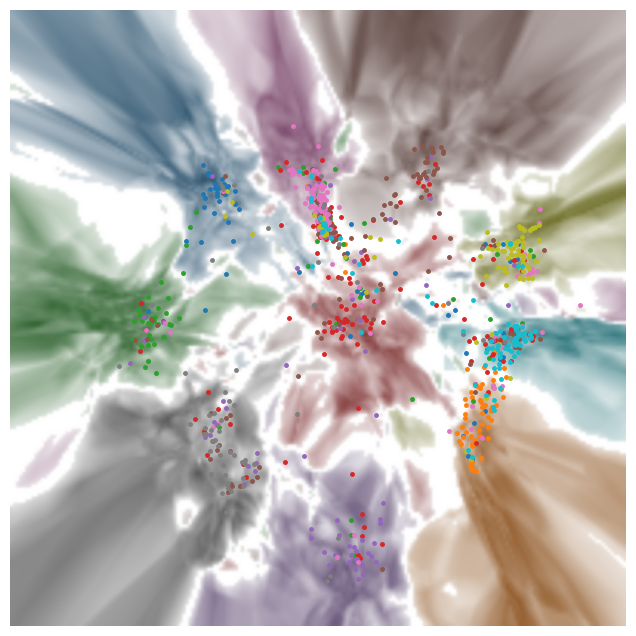

In [18]:
import os
VIS_MODEL_NAME = 'vis2'
encoded_Y_B = autoencoder.encoder(torch.Tensor(tar_features))
projector = TimeVisProjector(vis_model=model, content_path=REF_PATH, vis_model_name=VIS_MODEL_NAME, device="cpu")
from AlignVisAutoEncoder.visualizer_boundary import visualizer
vis = visualizer(ref_provider, ref_features[indices], projector, 200,[],'tab10')
save_dir = os.path.join('/home/yifan/projects' , "imgcontrast")
vis.savefig(200, path=os.path.join("/home/yifan/projects/deepdebugertool/DLVisDebugger/alignment_evaluation/img1.png"))

Computing decision regions ...


100%|██████████| 25/25 [00:00<00:00, 13281.52it/s]


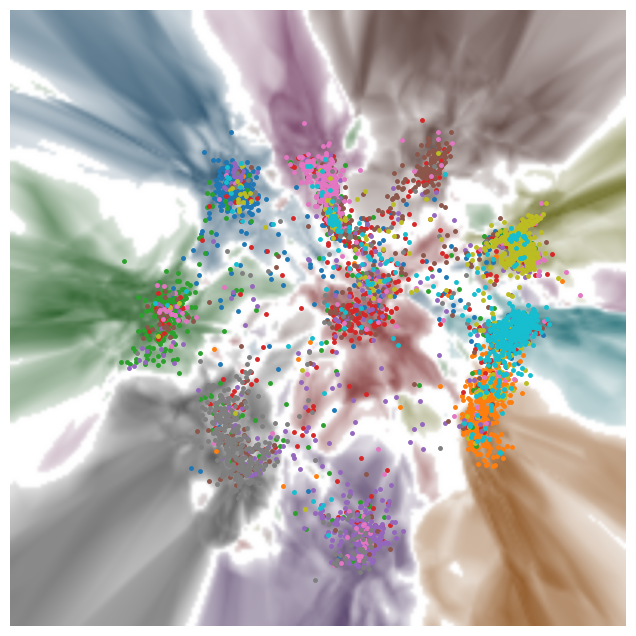

In [9]:
import os
VIS_MODEL_NAME = 'vis2'
encoded_Y_B = autoencoder.encoder(torch.Tensor(tar_features))
projector = TimeVisProjector(vis_model=model, content_path=REF_PATH, vis_model_name=VIS_MODEL_NAME, device="cpu")
from AlignVisAutoEncoder.visualizer_boundary import visualizer
vis = visualizer(ref_provider, ref_features, projector, 200,[],'tab10')
save_dir = os.path.join('/home/yifan/projects' , "imgcontrast")
vis.savefig(200, path=os.path.join("/home/yifan/projects/deepdebugertool/DLVisDebugger/alignment_evaluation/img1.png"))

In [30]:
import torch.optim as optim
import numpy as np
from pyemd import emd
import torch.nn as nn
from scipy.spatial.distance import cdist
from sklearn.neighbors import kneighbors_graph
import torch.nn.functional as F
from AlignVis.losses import KNNOverlapLoss, CKALoss, PredictionLoss, ConfidenceLoss



def kl_div_loss(P, Q):
    # Check if the input contains NaN, infinity, or very large values
    if not torch.isfinite(P).all() or not torch.isfinite(Q).all() or not torch.max(torch.abs(P)).item() < np.finfo(np.float32).max or not torch.max(torch.abs(Q)).item() < np.finfo(np.float32).max:
        # Replace NaN, infinity, or very large values with zeros
        P[~torch.isfinite(P) | (torch.abs(P) >= np.finfo(np.float32).max)] = 0
        Q[~torch.isfinite(Q) | (torch.abs(Q) >= np.finfo(np.float32).max)] = 0

    kl_divergence = torch.sum(P * torch.log(P / Q))

    # Calculate KL divergence between Q and P
    kl_divergence += torch.sum(Q * torch.log(Q / P))

    # Return the average KL divergence
    return kl_divergence.mean()

def gaussian_kernel(x1, x2, sigma=1.0):
    x1 = x1.unsqueeze(1)  # shape: (n1, 1, d)
    x2 = x2.unsqueeze(0)  # shape: (1, n2, d)
    dist = torch.sum((x1 - x2) ** 2, dim=-1)  # shape: (n1, n2)
    return torch.exp(-dist / (2 * sigma ** 2))

def mmd_loss(x1, x2, kernel=gaussian_kernel, sigma=1.0):
    n1, n2 = x1.size(0), x2.size(0)

    k11 = kernel(x1, x1, sigma=sigma).sum() / (n1 * (n1 - 1))
    k22 = kernel(x2, x2, sigma=sigma).sum() / (n2 * (n2 - 1))
    k12 = kernel(x1, x2, sigma=sigma).sum() / (n1 * n2)

    return k11 + k22 - 2 * k12



def earth_movers_distance(X, Y, k=5):
    X, Y = X.detach().numpy(), Y.detach().numpy()
    
    # Compute KNN graphs
    X_knn_graph = kneighbors_graph(X, k, mode='distance')
    Y_knn_graph = kneighbors_graph(Y, k, mode='distance')
    
    # Convert to dense NumPy arrays
    X_knn_matrix = X_knn_graph.toarray()
    Y_knn_matrix = Y_knn_graph.toarray()

    # Calculate the EMD between the KNN distance matrices
    distance_matrix = cdist(X_knn_matrix, Y_knn_matrix)
    first_histogram = np.ones(X_knn_matrix.shape[0]) / X_knn_matrix.shape[0]
    second_histogram = np.ones(Y_knn_matrix.shape[0]) / Y_knn_matrix.shape[0]

    loss = emd(first_histogram, second_histogram, distance_matrix)
    loss_tensor = torch.tensor(loss, requires_grad=True)

    return loss_tensor

def frobenius_norm_loss(predicted, target):
    return torch.norm(predicted - target, p='fro') / predicted.numel()

def prediction_loss(trans_X, Y):
    
    target_output = tar_provider.get_pred(TAR_EPOCH, Y.detach().numpy())
    # tar_output = self.get_pred(self.TAR_EPOCH, adjusted_input, self.tar_provider.content_path, self.tar_model)
    ref_output = tar_provider.get_pred(TAR_EPOCH, trans_X.detach().numpy())

    loss_ref_output = F.mse_loss(torch.tensor(ref_output), torch.tensor(target_output))
    loss_Rep = F.mse_loss(trans_X, Y)
        
    # loss = loss_tar_output + loss_Rep + self.alpha_for_pred_ref * loss_ref_output
    loss =  loss_Rep + 1 * loss_ref_output
    return loss

# Define hyperparameters
num_epochs = 10
batch_size = 100
learning_rate = 1e-4

# Define the loss function and the optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(autoencoder.parameters(), lr=learning_rate,weight_decay=1e-5)

alpha = 1 # weight for topological loss, adjust this according to your requirements


autoencoder = SimpleAutoencoder(input_dim,output_dim)
########### load pre autoencoder
checkpoint = torch.load("/home/yifan/projects/deepdebugertool/DLVisDebugger/AlignVisAutoEncoder/checkpoints/cak_1v1.pth")
autoencoder.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

######### train sample + generated boundary sample's => input  #############
from AlignVisAutoEncoder.data_loader import DataLoaderInit

indicates = np.random.choice(np.arange(50000), size=5000, replace=False)

input_X = np.concatenate((ref_provider.train_representation(REF_EPOCH)[indicates], ref_features[indices]),axis=0)
input_Y = np.concatenate((tar_provider.train_representation(TAR_EPOCH)[indicates], tar_features[indices]),axis=0)
data_loader_b = DataLoaderInit(input_X, input_Y, batch_size)
dataloader_b = data_loader_b.get_data_loader()

# Training loop
for epoch in range(num_epochs):
    # Initialize a list to store the predictions of unlabelled data
    unlabelled_preds = []
    for data_X, data_Y in dataloader_b: # Assuming you have a DataLoader instance with paired data (X, Y)
        # Zero the gradients
        optimizer.zero_grad()

        # Forward pass (encoding Y and decoding to X's space)
        transformed_Y = autoencoder.encoder(data_Y)
        recon_X = autoencoder.decoder(transformed_Y)
        transformed_X = autoencoder.decoder(data_X)

        ##### knn loss
        knn_overlap_loss = KNNOverlapLoss(k=15)

        knn_loss_encoder = knn_overlap_loss(input=transformed_Y, target=data_Y)

        knn_loss_decoder = knn_overlap_loss(input=recon_X, target=data_Y)

        # knn_loss = knn_overlap_loss(input=transformed_X, target=data_Y)
        ###### make ref' s distribution like tar
        mmd_loss_v = mmd_loss(recon_X,data_Y)
        # dis_loss = 0
        
        loss_f_decoder = knn_loss_decoder
        loss_f_encoder = knn_loss_encoder

        pred_loss = prediction_loss(recon_X, data_Y)

        

        #### CKA loss
        cka_loss_f = CKALoss(gamma=None, alpha=1e-8)
        cka_loss = cka_loss_f(data_Y,transformed_Y,recon_X)

        loss = loss_f_decoder + loss_f_encoder + pred_loss + cka_loss + 20 * mmd_loss_v

        # Backward pass
        loss.backward()

        # Update the weights
        optimizer.step()


    # Print the loss for each epoch
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}, Loss decoder: {loss_f_decoder.item():.4f},Loss encoder: {loss_f_encoder.item():.4f},pred_loss,{pred_loss.item():.4f},CKA,{cka_loss.item():.4f},mmd_loss:{mmd_loss_v}')

torch.save({
    'epoch': TAR_EPOCH,
    'model_state_dict': autoencoder.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'loss': loss
}, "/home/yifan/projects/deepdebugertool/DLVisDebugger/AlignVisAutoEncoder/checkpoints/drop_only_boundary.pth")


100%|██████████| 1/1 [00:00<00:00, 2309.64it/s]


Epoch [1/10], Loss: 8.4000, Loss decoder: 0.0811,Loss encoder: 0.0265,pred_loss,7.8034,CKA,0.0005,mmd_loss:0.02442150190472603


100%|██████████| 1/1 [00:00<00:00, 2832.08it/s]


Epoch [2/10], Loss: 8.5618, Loss decoder: 0.0635,Loss encoder: 0.0281,pred_loss,7.9813,CKA,0.0005,mmd_loss:0.024417748674750328


100%|██████████| 1/1 [00:00<00:00, 3692.17it/s]


Epoch [3/10], Loss: 7.9867, Loss decoder: 0.0675,Loss encoder: 0.0233,pred_loss,7.4066,CKA,0.0005,mmd_loss:0.024441635236144066


100%|██████████| 1/1 [00:00<00:00, 1693.98it/s]


Epoch [4/10], Loss: 8.7581, Loss decoder: 0.0651,Loss encoder: 0.0161,pred_loss,8.1882,CKA,0.0005,mmd_loss:0.024410102516412735


100%|██████████| 1/1 [00:00<00:00, 1374.28it/s]


Epoch [5/10], Loss: 8.4175, Loss decoder: 0.0779,Loss encoder: 0.0345,pred_loss,7.8158,CKA,0.0006,mmd_loss:0.02442856878042221


100%|██████████| 1/1 [00:00<00:00, 2796.20it/s]


Epoch [6/10], Loss: 8.8509, Loss decoder: 0.0699,Loss encoder: 0.0289,pred_loss,8.2638,CKA,0.0004,mmd_loss:0.024394910782575607


100%|██████████| 1/1 [00:00<00:00, 3170.30it/s]


Epoch [7/10], Loss: 8.6616, Loss decoder: 0.0715,Loss encoder: 0.0217,pred_loss,8.0792,CKA,0.0006,mmd_loss:0.024427644908428192


100%|██████████| 1/1 [00:00<00:00, 2746.76it/s]


Epoch [8/10], Loss: 8.5262, Loss decoder: 0.0747,Loss encoder: 0.0281,pred_loss,7.9349,CKA,0.0006,mmd_loss:0.024393130093812943


100%|██████████| 1/1 [00:00<00:00, 3034.95it/s]


Epoch [9/10], Loss: 8.8240, Loss decoder: 0.0627,Loss encoder: 0.0273,pred_loss,8.2453,CKA,0.0005,mmd_loss:0.024408627301454544


100%|██████████| 1/1 [00:00<00:00, 3090.87it/s]

Epoch [10/10], Loss: 8.4822, Loss decoder: 0.0675,Loss encoder: 0.0217,pred_loss,7.9045,CKA,0.0006,mmd_loss:0.02440187893807888


Computing decision regions ...


100%|██████████| 5/5 [00:00<00:00, 8630.26it/s]


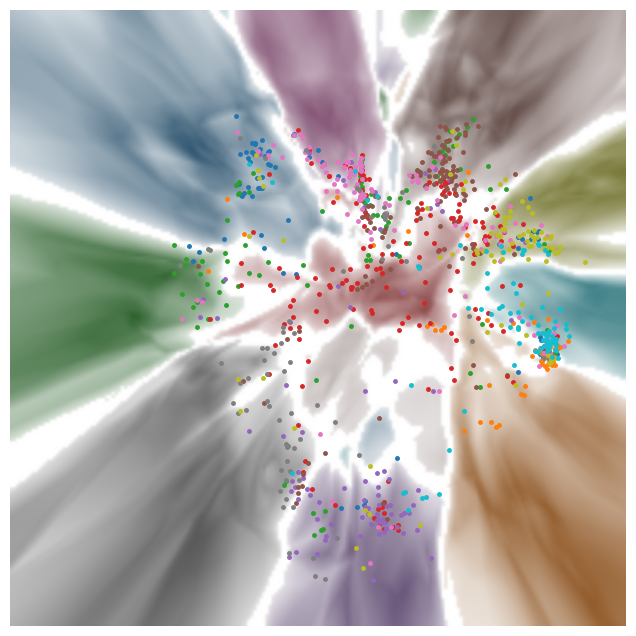

In [27]:
####### target gen boundary visualize in target
import os

VIS_MODEL_NAME = 'vis'
projector = TimeVisProjector(vis_model=model, content_path=CLEAN_PATH, vis_model_name=VIS_MODEL_NAME, device="cpu")
from AlignVisAutoEncoder.visualizer_boundary import visualizer
# from representationTrans.visualizer import visualizer
vis = visualizer(tar_provider, tar_features[indices], projector, 200,[],'tab10')
save_dir = os.path.join('/home/yifan/projects' , "imgcontrast")
vis.savefig(200, path=os.path.join("/home/yifan/projects/deepdebugertool/DLVisDebugger/alignment_evaluation/img1.png"))

In [ ]:
####### target gen boundary visualize in target
import os

VIS_MODEL_NAME = 'vis'
projector = TimeVisProjector(vis_model=model, content_path=CLEAN_PATH, vis_model_name=VIS_MODEL_NAME, device="cpu")
from AlignVisAutoEncoder.visualizer_boundary import visualizer
# from representationTrans.visualizer import visualizer
vis = visualizer(tar_provider, tar_features, projector, 200,[],'tab10')
save_dir = os.path.join('/home/yifan/projects' , "imgcontrast")
vis.savefig(200, path=os.path.join("/home/yifan/projects/deepdebugertool/DLVisDebugger/alignment_evaluation/img1.png"))

In [ ]:
import os
VIS_MODEL_NAME = 'vis2'
encoded_Y_B = autoencoder.encoder(torch.Tensor(tar_features))
projector = TimeVisProjector(vis_model=model, content_path=REF_PATH, vis_model_name=VIS_MODEL_NAME, device="cpu")
from AlignVisAutoEncoder.visualizer_boundary import visualizer
vis = visualizer(ref_provider, encoded_Y_B.detach().numpy(), projector, 200,[],'tab10')
save_dir = os.path.join('/home/yifan/projects' , "imgcontrast")
vis.savefig(200, path=os.path.join("/home/yifan/projects/deepdebugertool/DLVisDebugger/alignment_evaluation/img1.png"))

In [ ]:
from AlignVisAutoEncoder.visualizergrids import visualizer
VIS_MODEL_NAME = 'vis2'
projector = TimeVisProjector(vis_model=model, content_path=REF_PATH, vis_model_name=VIS_MODEL_NAME, device="cpu")
encoded_Y_B = autoencoder.encoder(torch.Tensor(tar_features))
vis = visualizer(tar_provider, autoencoder, np.dot(encoded_Y_B.detach().numpy(),I), projector, 200,[],True,'tab10')
# from representationTrans.visualizer import visualizer
# vis = visualizer(tar_provider, I,I, np.dot(tar_provider.test_representation(200), I), projector, 200,[predict_label_diff_indicates],'tab10')
save_dir = os.path.join('/home/yifan/projects' , "imgcontrast")


vis.savefig(200, path=os.path.join("/home/yifan/projects/deepdebugertool/DLVisDebugger/alignment_evaluation/img1.png"))

Computing decision regions ...


100%|██████████| 250/250 [00:00<00:00, 7952.43it/s]


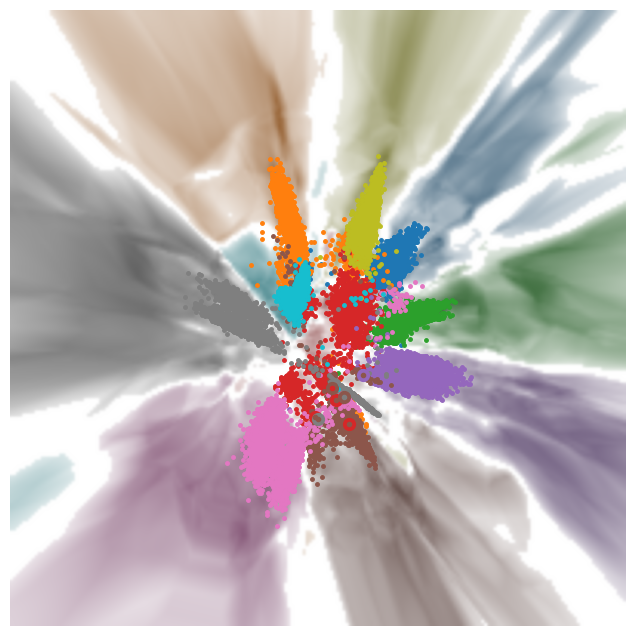

In [32]:
##### visuallize all data
import os
from singleVis.SingleVisualizationModel import VisModel
from singleVis.projector import TimeVisProjector
model = VisModel(ENCODER_DIMS, DECODER_DIMS)
VIS_MODEL_NAME = 'vis'
projector = TimeVisProjector(vis_model=model, content_path=REF_PATH, vis_model_name=VIS_MODEL_NAME, device="cpu")
Y = torch.Tensor(tar_provider.train_representation(TAR_EPOCH))
encoded_Y = autoencoder.encoder(Y)
I = np.eye(512)
from AlignVisAutoEncoder.visualizer import visualizer
# from representationTrans.visualizer import visualizer
vis = visualizer(tar_provider, ref_provider, autoencoder, np.dot(encoded_Y.detach().numpy(), I), projector, 200,[],'tab10')
save_dir = os.path.join('/home/yifan/projects' , "imgcontrast")
# os.makedirs(save_dir)

vis.savefig(REF_EPOCH, path=os.path.join("/home/yifan/projects/deepdebugertool/DLVisDebugger/alignment_evaluation/img2.png"))

In [ ]:
###### ref
import json
import os
from singleVis.SingleVisualizationModel import VisModel
from singleVis.projector import TimeVisProjector
model = VisModel(ENCODER_DIMS, DECODER_DIMS)
VIS_MODEL_NAME = 'vis2'

projector = TimeVisProjector(vis_model=model, content_path=REF_PATH, vis_model_name=VIS_MODEL_NAME, device="cpu")

I = np.eye(512)
# from AlignVisAutoEncoder.trans_visualizer import visualizer
from representationTrans.trans_visualizer_border import visualizer
vis = visualizer(ref_provider, I,I, ref_provider.train_representation(REF_EPOCH), projector, 200,[],'tab10')
save_dir = os.path.join('/home/yifan/projects' , "imgcontrast")
# os.makedirs(save_dir)

vis.savefig(REF_EPOCH, path=os.path.join("/home/yifan/projects/deepdebugertool/DLVisDebugger/alignment_evaluation/img2.png"))

In [ ]:
import os
VIS_MODEL_NAME = 'vis2'
encoded_Y_B = autoencoder.encoder(torch.Tensor(tar_features))
projector = TimeVisProjector(vis_model=model, content_path=REF_PATH, vis_model_name=VIS_MODEL_NAME, device="cpu")
from AlignVisAutoEncoder.visualizer_boundary import visualizer
vis = visualizer(ref_provider, encoded_Y_B.detach().numpy(), projector, 200,[],'tab10')
save_dir = os.path.join('/home/yifan/projects' , "imgcontrast")
vis.savefig(200, path=os.path.join("/home/yifan/projects/deepdebugertool/DLVisDebugger/alignment_evaluation/img1.png"))

In [ ]:
import os
VIS_MODEL_NAME = 'vis2'
projector = TimeVisProjector(vis_model=model, content_path=REF_PATH, vis_model_name=VIS_MODEL_NAME, device="cpu")
from AlignVisAutoEncoder.visualizer_boundary import visualizer
vis = visualizer(ref_provider, ref_features, projector, 200,[],'tab10')
save_dir = os.path.join('/home/yifan/projects' , "imgcontrast")
vis.savefig(200, path=os.path.join("/home/yifan/projects/deepdebugertool/DLVisDebugger/alignment_evaluation/img1.png"))

In [ ]:
import os
VIS_MODEL_NAME = 'vis'
projector = TimeVisProjector(vis_model=model, content_path=REF_PATH, vis_model_name=VIS_MODEL_NAME, device="cpu")
from AlignVisAutoEncoder.visualizer_boundary import visualizer
vis = visualizer(ref_provider, ref_features, projector, 200,[],'tab10')
save_dir = os.path.join('/home/yifan/projects' , "imgcontrast")
vis.savefig(200, path=os.path.join("/home/yifan/projects/deepdebugertool/DLVisDebugger/alignment_evaluation/img1.png"))

In [ ]:
from AlignVis_eval.Alignmenteval import Evaluator
eval = Evaluator(projector,ref_provider,tar_provider,REF_EPOCH,TAR_EPOCH)

eval.eval_nn_train_ref_in_ref(15)
eval.eval_nn_train_autoencoder(15, autoencoder )
eval.eval_boundary_nn_autoencoder(tar_features, autoencoder)